# SDFusion: Single-view Reconstruction (img2shape)

In [55]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"
max_split_size_mb = 1024
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = f"max_split_size_mb:{max_split_size_mb}"

In [56]:
# import libraries
import numpy as np
from PIL import Image
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint

import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionImage2ShapeOpt

seed = 2023
opt = SDFusionImage2ShapeOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device


[*] SDFusionImage2ShapeOption initialized.


In [58]:
# initialize SDFusion model
ckpt_path = 'saved_ckpt/sdfusion-img2shape.pth'

opt.init_model_args(ckpt_path=ckpt_path)


SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
[*] VQVAE: weight successfully load from: saved_ckpt/vqvae-snet-all.pth
[*] weight successfully load from: saved_ckpt/sdfusion-img2shape.pth
[*] setting ddim_steps=100
[*] Model has been created: SDFusionImage2ShapeModel
[*] "SDFusionImage2ShapeModel" loaded.


## SDFusion: Single-view Reconstruction (img2shape)

TODO: add sample results here

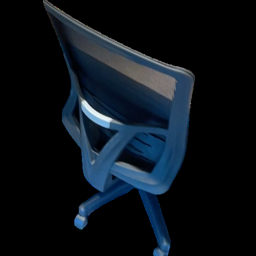

In [59]:
from utils.demo_util import preprocess_image
# img2shape
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

# input image. please use the grab_cut.ipynb to get the mask for your onw image
# input_img = "demo_data/revolving-chair.jpg"
# input_img = "demo_data/chair_back2.jpg"
# input_img = "demo_data/office.jpg"
input_img = "demo_data/office01_rot_masked.png"
# input_mask = "demo_data/revolving-chair-mask.png"
# input_mask = "demo_data/office_mask.png"
# no mask at all
input_mask = np.ones(np.array(Image.open(input_img)).shape[:2])
img, _ = preprocess_image(input_img, input_mask)

display(img)

Data shape for DDIM sampling is (1, 3, 16, 16, 16), eta 0.15
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████| 100/100 [00:12<00:00,  7.71it/s]


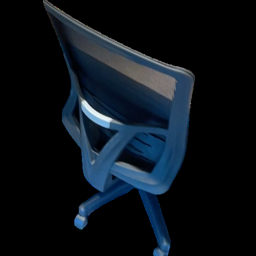

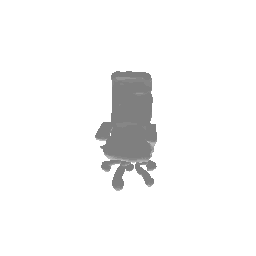

In [60]:
ngen = 1 # number of generated shapes
ddim_steps = 100
ddim_eta = 0.15
uc_scale = 5.

sdf_gen = SDFusion.img2shape(image=input_img, mask=input_mask, ddim_steps=ddim_steps, ddim_eta=ddim_eta, uc_scale=uc_scale)

mesh_gen = sdf_to_mesh(sdf_gen)
from pytorch3d.io import IO
from pytorch3d import io
IO().save_mesh(mesh_gen, f'{out_dir}/img2shape.ply')
final_verts, final_faces = mesh_gen.get_mesh_verts_faces(0)
io.save_obj(f'{out_dir}/img2shape.obj', final_verts, final_faces)
# vis as gif
gen_name = f'{out_dir}/img2shape.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

display(img)
display(ipy_image(gen_name))